<a href="https://colab.research.google.com/github/hamednasr/PyTorch/blob/main/GAN_FMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GANs for FashionMNIST
generating images with generative adversarial networks (GANs)

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
from torch.utils.data import DataLoader , TensorDataset

import sys

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [ ]:
# device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Import the data

In [ ]:
FashionMNIST = torchvision.datasets.FashionMNIST(root='sample_data',download=True)

In [ ]:
FashionMNIST

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: sample_data
    Split: Train

In [ ]:
FashionMNIST.data.shape

torch.Size([60000, 28, 28])

In [ ]:
FashionMNIST.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

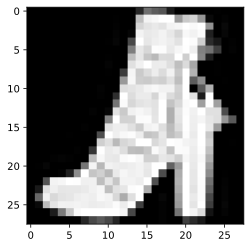

In [ ]:
plt.imshow(FashionMNIST.data[11,:,:],cmap='gray')

In [ ]:
FashionMNIST[11]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F04EE92A8D0>, 9)

In [ ]:
FashionMNIST[11][0]

In [ ]:
FashionMNIST[11][1]

9

In [ ]:
FashionMNIST.class_to_idx

{'Ankle boot': 9,
 'Bag': 8,
 'Coat': 4,
 'Dress': 3,
 'Pullover': 2,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'T-shirt/top': 0,
 'Trouser': 1}

In [ ]:
FashionMNIST.data[FashionMNIST.targets == 1].shape

torch.Size([6000, 28, 28])

In [ ]:
data = FashionMNIST.data
labels = FashionMNIST.targets

In [ ]:
data = data[(labels==1) | (labels==9) | (labels==4)]
labels = labels[(labels==1) | (labels==9) | (labels==4)]

In [ ]:
dataNorm = data / data.max()
dataNorm = 2 * dataNorm - 1

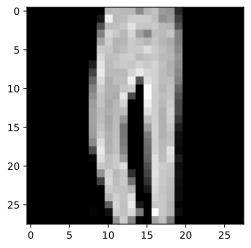

In [ ]:
plt.imshow(dataNorm[11,:,:],cmap='gray')

In [ ]:
batchsize = 128
train_set = TensorDataset(dataNorm,labels)

In [ ]:
train_set.tensors[1].shape

torch.Size([12000])

In [ ]:
train_loader = DataLoader(train_set,batch_size=batchsize,shuffle=True,drop_last=True)

In [ ]:
for X,y in train_loader:
  print(X.shape)

torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([128, 28, 28])
torch.Size([

# Create classes for the discriminator and generator

In [ ]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(28*28,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,1)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.sigmoid( x )

dnet = discriminatorNet()
y = dnet(torch.randn(10,784))
y

tensor([[0.4826],
        [0.5128],
        [0.4878],
        [0.5039],
        [0.4982],
        [0.5007],
        [0.5190],
        [0.5443],
        [0.4945],
        [0.5266]], grad_fn=<SigmoidBackward0>)

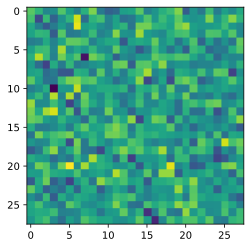

In [ ]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(64,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,784)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.tanh( x )


gnet = generatorNet()
y = gnet(torch.randn(10,64))

plt.imshow(y[0,:].detach().squeeze().view(28,28));

# Train the models

In [ ]:
# loss function (same for both phases of training)
lossfun = nn.BCELoss()

# create instances of the models
dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

# optimizers (same algo but different variables b/c different parameters)
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0005)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0005)

In [ ]:
num_epochs = 500

losses  = np.zeros((num_epochs,2))
disDecs = np.zeros((num_epochs,2)) # disDecs = discriminator decisions

for epochi in range(num_epochs):

  for X,y in train_loader:
    
    # create minibatches of REAL and FAKE images 
    # randidx     = torch.randint(dataT.shape[0],(batchsize,))
    real_images = X.reshape(batchsize,784).to(device)
    fake_images = gnet( torch.randn(batchsize,64).to(device) ) # output of generator

    # labels used for real and fake images
    real_labels = torch.ones(batchsize,1).to(device)
    fake_labels = torch.zeros(batchsize,1).to(device)



    ### ---------------- Train the discriminator ---------------- ###

    # forward pass and loss for REAL pictures
    pred_real   = dnet(real_images)              # REAL images into discriminator
    d_loss_real = lossfun(pred_real,real_labels) # all labels are 1
    
    # forward pass and loss for FAKE pictures
    pred_fake   = dnet(fake_images)              # FAKE images into discriminator
    d_loss_fake = lossfun(pred_fake,fake_labels) # all labels are 0
    
    # collect loss (using combined losses)
    d_loss = d_loss_real + d_loss_fake
    losses[epochi,0]  = d_loss.item()
    disDecs[epochi,0] = torch.mean((pred_real>.5).float()).detach()

    # backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    
    

    ### ---------------- Train the generator ---------------- ###

    # create fake images and compute loss
    fake_images = gnet( torch.randn(batchsize,64).to(device) )
    pred_fake   = dnet(fake_images)
    
    # compute and collect loss and accuracy
    g_loss = lossfun(pred_fake,real_labels)
    losses[epochi,1]  = g_loss.item()
    disDecs[epochi,1] = torch.mean((pred_fake>.5).float()).detach()
    
    # backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    
    # print out a status message
    if (epochi+1)%50==0:
      msg = f'Finished epoch {epochi+1}/{num_epochs}'
      sys.stdout.write('\r' + msg)
  

Finished epoch 500/500

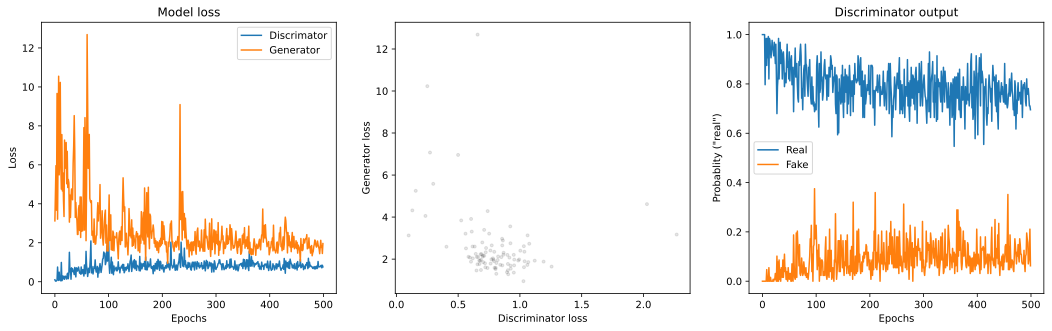

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([200,300])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(disDecs)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

# Visualizing the generated images

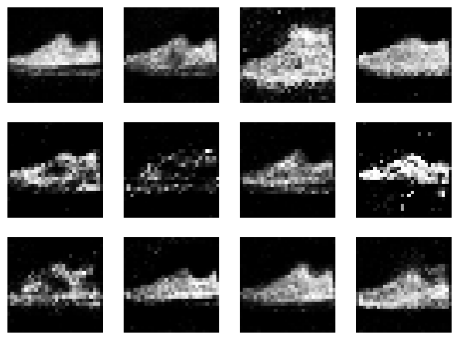

In [ ]:
gnet.eval()
fake_data = gnet(torch.randn(12,64).to(device)).cpu()

fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')

plt.show()